Подключаемые библиотеки

In [1]:
import re
import urllib2
import math
import numpy as np
import scipy.interpolate as ip
import pandas as pd
import pandas.io.data as web
import matplotlib.pyplot as plt
import scipy.optimize as sco

from bs4 import BeautifulSoup

/usr/lib64/python2.7/site-packages/pandas/io/data.py:33: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


Настройки отображения графиков:

In [2]:
%matplotlib inline
plt.style.use('fivethirtyeight') # The most fanciest styles are 'ggplot' and 'fivethirtyeight'
# All available styles may be checked by
#print plt.style.available

Максимальный уровень волатильности, допустимый для данного инвестора

In [3]:
max_risk = 0.25

Глобальные переменные

In [4]:
data = pd.DataFrame()
symbols = []
start_prices = []
end_prices = []
trading_days = []
num_of_days = 0

Генерация достижимого множества

In [5]:
def get_feasible_set(num_of_portfolios):
    global feasible_returns
    global feasible_volatilities
    global feasible_weights
    
    feasible_returns = []
    feasible_volatilities = []
    feasible_weights = []
    
    p = 0
    while p < num_of_portfolios:
        # Generating weights
        weights = np.random.random(len(symbols))
        weights /= np.sum(weights)
    
        vol = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * num_of_days, weights)))
        if vol <= max_risk:
            # Expected returns
            feasible_returns.append(np.sum(returns.mean() * weights) * num_of_days)
            # Volatilities
            feasible_volatilities.append(np.sqrt(np.dot(weights.T, np.dot(returns.cov() * num_of_days, weights))))
            feasible_weights.append(weights)
            p += 1
        
    feasible_returns = np.array(feasible_returns)
    feasible_volatilities = np.array(feasible_volatilities)
    feasible_weights = np.array(feasible_weights)

Вычисление эффективного множества

In [6]:
def get_effective_set(min_return, max_return, step):
    global effective_returns
    global effective_volatilities
    global effective_weights

    effective_volatilities = []
    effective_returns = []
    effective_weights = []
    
    print len(symbols)
    
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bnds = tuple((0, 1) for x in range(len(symbols)))

    for y in np.linspace(min_return, max_return, step):
        cons = ({'type': 'eq', 'fun': lambda x: statistics(x)[1] - y}, {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        result = sco.minimize(min_volatility, len(symbols) * [1. / len(symbols),], method='SLSQP', bounds=bnds, constraints=cons)
        if result['fun'] <= max_risk:
            effective_volatilities.append(result['fun'])
            effective_returns.append(y)
            effective_weights.append(result['x'])
    
    effective_volatilities = np.array(effective_volatilities)
    effective_returns = np.array(effective_returns)
    effective_weights = np.array(effective_weights)

Функция, получающая веса бумаг в портфеле в качестве входных параметров, и возвращающая массив данных о портфеле в формате [волатильность, доходность, коэффициент Шарпа]

In [7]:
def statistics(weights):
    global num_of_days
    weights = np.array(weights)
    portfolio_return = get_portfolio_return(weights)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * num_of_days, weights)))
    
    return np.array([portfolio_volatility, portfolio_return, portfolio_return / portfolio_volatility])

Функция вычисления доходности портфеля

In [8]:
def get_portfolio_return(weights):
    global start_prices
    global end_prices
    portfolio_start_price = 0
    portfolio_end_price = 0

    for w, sp, ep in zip(weights, start_prices, end_prices):
        portfolio_start_price = portfolio_start_price + w * sp
        portfolio_end_price = portfolio_end_price + w * ep
    return ((portfolio_end_price - portfolio_start_price) / portfolio_start_price)
    #return np.sum(returns.mean() * weights) * num_of_days

Функция, показывающая основные показатели инвестиционного портфеля а также входящие в него ценные бумаги

In [24]:
def show(weights):
    global trading_days
    print "Investment period: " + trading_days[0] + " - " + trading_days[-1]
    print "Risk limit: " + str(max_risk)
    print "Portfolio volatility: " + str( statistics(weights)[0].round(3) )
    print "Portfolio return: " + str(statistics(weights)[1].round(3) )   
    print "Sharpe ratio: "  + str(statistics(weights)[2].round(3) )  
    print ""
    
    for sym, w in zip(symbols, weights):
        if w.round(3) > 0.001:
            print (sym + ': ' + str( w.round(3) ) )

Функция вычисления портфеля с максимальным коэффицентом Шарпа (отношением доходность/волатильность)

In [10]:
def get_max_sharpe_portfolio():
    max_sharpe = 0
    max_sharpe_portfolio = []
    for r, v, w in zip(effective_returns, effective_volatilities, effective_weights):
        if r / v > max_sharpe:
            max_sharpe =  r / v
            max_sharpe_portfolio = w
    return max_sharpe_portfolio

Функция вычисления портфеля с минимальной волатильностью

In [11]:
def get_min_variance():
    min_variace = 10
    min_variance_portfolio = []
    for v, w in zip(effective_volatilities, effective_weights):
        if v < min_variace:
            min_variace =  v
            min_variance_portfolio = w
            
    return min_variance_portfolio

Функция для получения списка компаний, входящих в S&P500

In [12]:
def get_sp500():
    site = "http://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    hdr = {'User-Agent': 'Mozilla/5.0'}
    req = urllib2.Request(site, headers=hdr)
    page = urllib2.urlopen(req)
    soup = BeautifulSoup(page)

    table = soup.find('table', {'class': 'wikitable sortable'})
    sector_tickers = dict()
    for row in table.findAll('tr'):
        col = row.findAll('td')
        if len(col) > 0:
            sector = str(col[3].string.strip()).lower().replace(' ', '_')
            ticker = str(col[0].string.strip())
            date = str(col[6]).replace('<td>', '').replace('</td>', '')
            #if date < historical_end_date:
            if sector not in sector_tickers:
                sector_tickers[sector] = list()
            sector_tickers[sector].append(ticker)

    return sector_tickers

Функция, возвращающая дату первого торгового дня для акций данной компании (первого дня, по которому доступна информация о цене)

In [13]:
def get_first_trading_day(sym):
    for i in range(0, len(data[sym]) ):
        if math.isnan(data[sym][i]):
            continue
        else:
            return str(data[sym].axes[0][i])

In [14]:
def get_nearest_trading_day(day):
    global trading_days
    if day in trading_days:
        return day
    else:
        for i in range(0, len(trading_days)):
            if trading_days[i] > day:
                return trading_days[i]
            else:
                return trading_days[-1]

In [15]:
def get_price(symbol, day):
    return data[sym][get_nearest_trading_day(day)], get_nearest_trading_day(day)

Функция определения минимального отклонения:

In [16]:
def min_volatility(weights):
    return statistics(weights)[0]

Функция составления массива дней, по которым доступны котировки

In [17]:
def set_trading_days(data, symbols, num_of_days):
    global trading_days
    
    for sym in symbols:
        trading_days = []
        for i in range(0, num_of_days):
            trading_days.append( str( re.split(' ', str(data[sym].axes[0][i]))[0]) )
            
        if len(trading_days) == num_of_days:
            break
            
    return len(trading_days)

In [22]:
def fetch_data(symbols, start_date, end_date):
    global data
    global start_prices
    global end_prices
    global num_of_days
    global returns
    
    #
    data = pd.DataFrame()
    num_of_days = 0
    fetched_symbols = []
    for sym in symbols:
        try:
            data[sym]  = web.DataReader(sym, data_source='yahoo', start=start_date, end=end_date)['Adj Close']
            fetched_symbols.append(sym)
            if data[sym].size > num_of_days:
                num_of_days = data[sym].size
        except IOError:
            print sym + ': no data available'
            continue
    
    data.column = fetched_symbols
    
    for sym in symbols:
        if sym not in fetched_symbols:
            symbols.remove(sym)
    
    set_trading_days(data, fetched_symbols, num_of_days)
    #print get_nearest_trading_day(start_date)
    #print get_nearest_trading_day(end_date)
    
    # Вычисление логарифмически нормализованых доходностей (отношение уровня закрытия текущего дня к предыдущему) за исторический период
    returns = np.log(data / data.shift(1))
    
    #
    start_prices = []
    end_prices = []
    for sym in fetched_symbols:
        start_prices.append(data[sym][get_nearest_trading_day(start_date)])
        end_prices.append(data[sym][get_nearest_trading_day(end_date)])
    
    print str(len(fetched_symbols)) + ' symbols fetched for ' + str(len(trading_days)) + ' trading days from ' + get_nearest_trading_day(start_date) + ' to ' + get_nearest_trading_day(end_date)

In [19]:
sp500 = get_sp500()
for sector in sp500:
    print sector + ": " + str(len(sp500[sector]) ) + " companies"
#    print sp500[sector]
#    print '\n'

industrials: 67 companies
energy: 40 companies
consumer_discretionary: 85 companies
utilities: 29 companies
telecommunications_services: 5 companies
materials: 27 companies
health_care: 56 companies
consumer_staples: 38 companies
financials: 90 companies
information_technology: 67 companies


/usr/lib/python2.7/site-packages/bs4/__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


In [20]:
symbols = []
for sym in sp500['materials']:
    symbols.append(sym)
#for sector in sp500:
#    for i in sp500[sector]:
#        symbols.append(i) 
print symbols

['APD', 'ARG', 'AA', 'AVY', 'BLL', 'CF', 'DOW', 'DD', 'EMN', 'ECL', 'FMC', 'FCX', 'IP', 'IFF', 'LYB', 'MLM', 'WRK', 'MON', 'MOS', 'NEM', 'NUE', 'OI', 'PPG', 'PX', 'SEE', 'SHW', 'VMC']


Получаем цены закрытия (close prices) для всего исторического периода:

In [23]:
fetch_data(symbols, '2014-01-01', '2015-01-01')

26 symbols fetched for 252 trading days from 2014-01-02 to 2014-12-31


In [26]:
%%time
get_effective_set(0.0, 0.7, 50)

26
CPU times: user 37.4 s, sys: 15 ms, total: 37.4 s
Wall time: 37.4 s


In [27]:
optimal_sharpe = get_max_sharpe_portfolio()
show(optimal_sharpe)

Investment period: 2014-01-02 - 2014-12-31
Risk limit: 0.25
Portfolio volatility: 0.131
Portfolio return: 0.414
Sharpe ratio: 3.171

BLL: 0.361
CF: 0.03
DD: 0.097
IP: 0.008
NEM: 0.037
SHW: 0.466


In [33]:
def test(weights, start_date, end_date):
    test_symbols = []
    test_weights = []
    test_data = pd.DataFrame()
    
    # showing generated portfolio
    show(weights)
    
    # setting up the new set (from the companies in portfolio above)
    for s, w in zip(symbols, weights):
        if w.round(3) > 0.001:
            test_symbols.append(s)
            test_weights.append(w)
            
    # Fetching data for a new period
    fetch_data(test_symbols, start_date, end_date)
    
    print '\nInvestment period: ' + str(start_date) + ' - ' + str(end_date)
    
    print 'Prices on ' + start_date + ':'
    for sym in test_symbols:
        print sym + ': '
    
    print '\nPrices on ' + end_date + ':'  
    for sym in test_symbols:
        print sym + ': '
    #get_portfolio_return(test_weights)

In [34]:
test(optimal_sharpe, '2015-01-01', '2016-01-01')

Investment period: 2014-01-02 - 2014-12-31
Risk limit: 0.25
Portfolio volatility: 0.131
Portfolio return: 0.414
Sharpe ratio: 3.171

BLL: 0.361
CF: 0.03
DD: 0.097
IP: 0.008
NEM: 0.037
SHW: 0.466
6 symbols fetched for 252 trading days from 2015-01-01 to 2016-01-01

Investment period: 2015-01-01 - 2016-01-01
Prices on 2015-01-01:
BLL: 
CF: 
DD: 
IP: 
NEM: 
SHW: 

Prices on 2016-01-01:
BLL: 
CF: 
DD: 
IP: 
NEM: 
SHW: 


In [131]:
minimal_volatility = get_min_variance()
show(minimal_volatility)

Investment period: 2014-01-01 - 2015-01-01
Risk limit: 0.25
Portfolio volatility: 0.127
Portfolio return: 0.205
Sharpe ratio: 1.613

AAPL: 0.194
TSS: 0.185
AVY: 0.17
BLL: 0.306
CF: 0.145


In [132]:
test(minimal_volatility)

Investment period: 2014-01-01 - 2015-01-01
Risk limit: 0.25
Portfolio volatility: 0.127
Portfolio return: 0.205
AAPL (0.194): 
	start: 75.683
	  end: 107.945
	 rate: 42.6%
TSS (0.185): 
	start: 32.081
	  end: 33.655
	 rate: 4.9%
AVY (0.17): 
	start: 47.117
	  end: 50.63
	 rate: 7.5%
BLL (0.306): 
	start: 50.592
	  end: 67.663
	 rate: 33.7%
CF (0.145): 
	start: 44.358
	  end: 52.783
	 rate: 19.0%
PORTFOLIO:
	start: 50.553
	  end: 64.154
	 rate: 26.9%


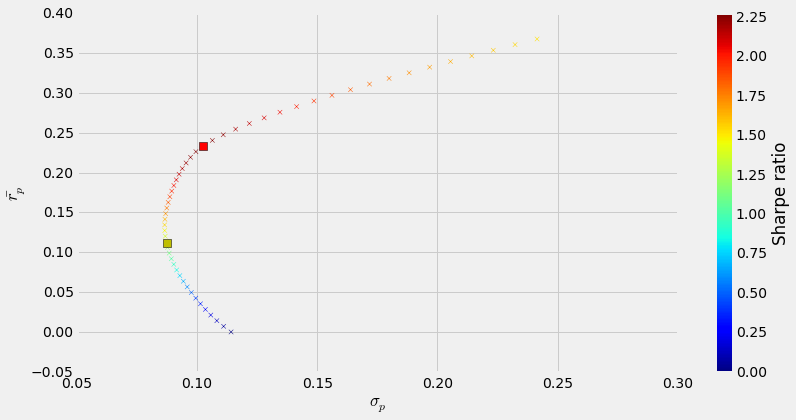

In [156]:
plt.figure(figsize=(12, 6))

x_sharpe = statistics(optimal_sharpe)[0]
y_sharpe = statistics(optimal_sharpe)[1]

x_min_vol = statistics(minimal_volatility)[0]
y_min_vol = statistics(minimal_volatility)[1]

#plt.scatter(feasible_volatilities, feasible_returns, c = feasible_returns / feasible_volatilities, marker='o')
plt.scatter(effective_volatilities, effective_returns, c = effective_returns / effective_volatilities, marker='x')
plt.plot(x_sharpe, y_sharpe, 'rs', markersize=8.0) # portfolio with highest Sharpe ratio
plt.plot(x_min_vol, y_min_vol, 'ys', markersize=8.0) # portfolio with highest Sharpe ratio

plt.colorbar(label='Sharpe ratio')
plt.xlabel(r'$\sigma_p$')
plt.ylabel(r'$\bar{r_p}$')


In [201]:
print data['AAPL']['2014-01-02']

75.682745


In [ ]:
get_close